**Tech Challenge: exportação de vinhos**

Integrantes: Jackson, Haendel e Gabriel Oliveira

Entrega: 05/07/2023

# Dataset de vinhos

[Link para download do csv](http://vitibrasil.cnpuv.embrapa.br/download/ExpVinho.csv)

## Leitura dos dados

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import numpy as np

pd.options.display.float_format = "{:.2f}".format

In [2]:
wine_data = pd.read_csv('./data/raw/ExpVinho.csv', sep=';')
wine_data.drop(columns=['Id'], inplace=True)
wine_data.rename(columns={'País':'pais_destino'}, inplace=True)

In [3]:
wine_data.head()

,pais_destino,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,1974,...,2017,2017.1,2018,2018.1,2019,2019.1,2020,2020.1,2021,2021.1
0,Afeganistão,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,46
1,África do Sul,0,0,0,0,0,0,0,0,0,...,0,0,0,0,26,95,4,21,0,0
2,"Alemanha, República Democrática",0,0,0,0,4168,2630,12000,8250,0,...,15467,87702,10794,45382,3660,25467,6261,32605,2698,6741
3,Angola,0,0,0,0,0,0,0,0,0,...,10170,61680,477,709,345,1065,0,0,0,0
4,Anguilla,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Columns: 105 entries, pais_destino to 2021.1
dtypes: int64(104), object(1)
memory usage: 101.8+ KB


In [5]:
wine_data.isna().sum().sum()

0

## Processamento e limpeza

### pd.melt()

In [6]:
wine_melted = pd.melt(wine_data, id_vars='pais_destino')
wine_melted.head()

,pais_destino,variable,value
0,Afeganistão,1970,0
1,África do Sul,1970,0
2,"Alemanha, República Democrática",1970,0
3,Angola,1970,0
4,Anguilla,1970,0


### Criando variável 'ano'

In [7]:
wine_melted['ano'] = wine_melted['variable'].astype(str).str[:4].astype('datetime64').dt.year
wine_melted.head()

,pais_destino,variable,value,ano
0,Afeganistão,1970,0,1970
1,África do Sul,1970,0,1970
2,"Alemanha, República Democrática",1970,0,1970
3,Angola,1970,0,1970
4,Anguilla,1970,0,1970


In [8]:
wine_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pais_destino  12896 non-null  object
 1   variable      12896 non-null  object
 2   value         12896 non-null  int64 
 3   ano           12896 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 403.1+ KB


### Criação de dfs contendo as linhas de cada variável numérica

In [17]:
wine_melted.loc[wine_melted.variable.str.len() == 4]

,pais_destino,variable,value,ano
0,Afeganistão,1970,0,1970
1,África do Sul,1970,0,1970
2,"Alemanha, República Democrática",1970,0,1970
3,Angola,1970,0,1970
4,Anguilla,1970,0,1970
...,...,...,...,...
12767,Tuvalu,2021,0,2021
12768,Uruguai,2021,136774,2021
12769,Vanuatu,2021,0,2021
12770,Venezuela,2021,26415,2021


In [18]:
# DF para linhas com informação de litros exportados
melted_litros = wine_melted.loc[wine_melted.variable.str.len() == 4]
melted_litros.rename(columns={'value':'litros_exportados'}, inplace=True)
melted_litros = melted_litros[['pais_destino','ano','litros_exportados']]

c:\Users\Jackson Simionato\.conda\envs\gis\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
melted_litros.head()

,pais_destino,ano,litros_exportados
0,Afeganistão,1970,0
1,África do Sul,1970,0
2,"Alemanha, República Democrática",1970,0
3,Angola,1970,0
4,Anguilla,1970,0


In [20]:
# DF para linhas com informação de valor exportado (US$)
melted_valor = wine_melted.loc[wine_melted.variable.str.len() == 6]
melted_valor.rename(columns={'value':'valor_exportacao'}, inplace=True)
melted_valor = melted_valor[['pais_destino','ano','valor_exportacao']]
display(melted_valor.head())

c:\Users\Jackson Simionato\.conda\envs\gis\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,pais_destino,ano,valor_exportacao
124,Afeganistão,1970,0
125,África do Sul,1970,0
126,"Alemanha, República Democrática",1970,0
127,Angola,1970,0
128,Anguilla,1970,0


### Merge dos dois DFs em um único DataFrame

In [25]:
df_wine_por_ano = melted_litros.merge(melted_valor, on=['pais_destino','ano'])
df_wine_por_ano.head(10)

,pais_destino,ano,litros_exportados,valor_exportacao
0,Afeganistão,1970,0,0
1,África do Sul,1970,0,0
2,"Alemanha, República Democrática",1970,0,0
3,Angola,1970,0,0
4,Anguilla,1970,0,0
5,Antígua e Barbuda,1970,0,0
6,Antilhas Holandesas,1970,280,207
7,Argentina,1970,0,0
8,Aruba,1970,0,0
9,Austrália,1970,0,0


### Filtragem dos anos de interesse (últimos 15)

In [22]:
list_15_anos = list(df_wine_por_ano.ano.unique())[-15:]
print(list_15_anos)

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [26]:
df_wine_por_ano_15_anos = df_wine_por_ano.query('ano in @list_15_anos').reset_index(drop=True)
df_wine_por_ano_15_anos.head()

,pais_destino,ano,litros_exportados,valor_exportacao
0,Afeganistão,2007,0,0
1,África do Sul,2007,0,0
2,"Alemanha, República Democrática",2007,119512,238052
3,Angola,2007,25931,49753
4,Anguilla,2007,0,0


### Cálculo do montante exportado por país nos últimos 15 anos

In [27]:
df_wine_15_anos_soma = df_wine_por_ano_15_anos[['pais_destino',	'litros_exportados', 'valor_exportacao']].groupby('pais_destino').sum().reset_index()
df_wine_15_anos_soma

,pais_destino,litros_exportados,valor_exportacao
0,Afeganistão,11,46
1,"Alemanha, República Democrática",1020933,2739079
2,Angola,190731,621181
3,Anguilla,0,0
4,Antilhas Holandesas,114027,160864
...,...,...,...
119,Vanuatu,18,31
120,Venezuela,52995,83847
121,Vietnã,9669,12736
122,África do Sul,30,116


In [28]:
# Ordenando por litros exportados
df_wine_15_anos_soma.sort_values(by='litros_exportados', ascending=False, inplace=True)
df_wine_15_anos_soma.reset_index(drop=True, inplace=True)
df_wine_15_anos_soma.head(15)

,pais_destino,litros_exportados,valor_exportacao
0,Rússia,39230153,25559026
1,Paraguai,25423559,32364257
2,Estados Unidos,3822251,10046712
3,China,2411701,4372268
4,Espanha,1993000,3808552
5,Japão,1502311,2612375
6,Países Baixos,1410166,4119122
7,Reino Unido,1305329,4717554
8,Haiti,1238100,1586194
9,"Alemanha, República Democrática",1020933,2739079


In [29]:
#Criação
df_wine_15_anos_soma['pais_origem'] = 'Brasil'
df_wine_15_anos_soma = df_wine_15_anos_soma[['pais_origem','pais_destino','litros_exportados','valor_exportacao']]
df_wine_15_anos_soma.head()

,pais_origem,pais_destino,litros_exportados,valor_exportacao
0,Brasil,Rússia,39230153,25559026
1,Brasil,Paraguai,25423559,32364257
2,Brasil,Estados Unidos,3822251,10046712
3,Brasil,China,2411701,4372268
4,Brasil,Espanha,1993000,3808552


In [7]:
df_wine_15_anos_soma.to_csv('./data/processed/wine_data_15_years.csv', index=False)
df_wine_15_anos_soma = pd.read_csv('./data/processed/wine_data_15_years.csv')

# Dataset de dados climáticos: usando Climate API WorldBank (on hold, está fora do ar)

Nesta análise será explorada a relação entre o **consumo de vinhos** e o clima de cada país, mais precisamente as **temperaturas mínimas, médias e máximas anuais**. Desta forma, podem ser encontradas correlações interessantes entre climas mais frios e um maior consumo da bebida.

Claro que outros fatores demográficos e economicos também são relevantes para esse tipo de estudo, por isso a questão climática será abordada de maneira complementar a estas outras informações

Dataset usado: [Climate API](https://datahelpdesk.worldbank.org/knowledgebase/articles/889386-developer-information-overview)

Como usar: [Artigo no HatariLabs](https://hatarilabs.com/ih-en/how-to-download-climate-change-data-from-the-world-bank-data-api-with-python)

In [32]:
!pip install wbpy
import wbpy
from pprint import pprint

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681896 sha256=a725ace2540853bda8582d60d7c2422e79922f219818395afe016c3dea947894
  Stored in directory: c:\users\jackson simionato\appdata\local\pip\cache\wheels\0e\06\e8\7ee176e95ea9a8a8c3b3afcb1869f20adbd42413d4611c6eb4
Successfully built pycountry


In [33]:
c_api = wbpy.ClimateAPI()

In [34]:
c_api.ARG_DEFINITIONS

{'instrumental_types': {'pr': 'Precipitation (rainfall and assumed water equivalent), in millimeters',
  'tas': 'Temperature, in degrees Celsius'},
 'instrumental_intervals': ['year', 'month', 'decade'],
 'modelled_types': {'tmin_means': 'Average daily minimum temperature, Celsius',
  'tmax_means': 'Average daily maximum temperature, Celsius',
  'tmax_days90th': "Number of days with max temperature above the control period's 90th percentile (hot days)",
  'tmin_days90th': "Number of days with min temperature above the control period's 90th percentile (warm nights)",
  'tmax_days10th': "Number of days with max temperature below the control period's 10th percentile (cool days)",
  'tmin_days10th': "Number of days with min temperature below the control period's 10th percentile (cold nights)",
  'tmin_days0': 'Number of days with min temperature below 0 degrees Celsius',
  'ppt_days': 'Number of days with precipitation > 0.2mm',
  'ppt_days2': 'Number of days with precipitation > 2mm',
  '

Para extrair os dados dos países de interesse, precisaremos dos códigos ISO 3166-1 de cada país, que funciona como um código de identificação padronizado globalmente

## Códigos ISO 3166-1

Fonte: https://pt.wikipedia.org/wiki/ISO_3166-1

In [22]:
url_iso = 'https://pt.wikipedia.org/wiki/ISO_3166-1'
pd_iso = pd.read_html(url_iso)

In [23]:
# Retornou uma lista de dataframes, porque há mais de uma tabela no link. Vamos usar a primeira tabela da url
type(pd_iso)

list

In [24]:
pd_iso = pd_iso[0]
pd_iso.head()

,núm,alfa-3,alfa-2,País,País e bandeira
0,4,AFG,AF,Afeganistão,Afeganistão
1,710,ZAF,ZA,África do Sul,África do Sul
2,248,ALA,AX,"Aland, Ilhas",Ilhas Åland
3,8,ALB,AL,Albânia,Albânia
4,276,DEU,DE,Alemanha,Alemanha


In [25]:
wine_df_15_anos_iso = wine_df_15_anos.merge(pd_iso, left_on='pais_destino', right_on='País')

In [26]:
wine_df_15_anos_iso

,pais_origem,pais_destino,litros_exportados,valor_exportacao,núm,alfa-3,alfa-2,País,País e bandeira
0,Brasil,Rússia,39230153,25559026,643,RUS,RU,Rússia,Rússia
1,Brasil,Paraguai,25423559,32364257,600,PRY,PY,Paraguai,Paraguai
2,Brasil,Estados Unidos,3822251,10046712,840,USA,US,Estados Unidos,Estados Unidos
3,Brasil,China,2411701,4372268,156,CHN,CN,China,China
4,Brasil,Espanha,1993000,3808552,724,ESP,ES,Espanha,Espanha
...,...,...,...,...,...,...,...,...,...
88,Brasil,Tanzânia,0,0,834,TZA,TZ,Tanzânia,Tanzânia
89,Brasil,Senegal,0,0,686,SEN,SN,Senegal,Senegal
90,Brasil,Jamaica,0,0,388,JAM,JM,Jamaica,Jamaica
91,Brasil,Costa do Marfim,0,0,384,CIV,CI,Costa do Marfim,Costa do Marfim


Não foi possível obter o codigo ISO para todos os países, pois existem diferenças nas nomenclaturas dos países entre os DFs.

### Padronização nome dos países

In [27]:
# Criação de lista com países do df de vinhos que precisam de correção no nome
list_nome_paises_correcao_wine = [nome_pais for nome_pais in list(wine_df_15_anos.pais_destino) if nome_pais not in list(wine_df_15_anos_iso.pais_destino)]

In [28]:
list_nome_paises_correcao_wine

['Países Baixos',
 'Reino Unido',
 'Alemanha, República Democrática',
 'Tcheca, República',
 'Curaçao',
 'Antilhas Holandesas',
 'Estônia',
 'Taiwan (FORMOSA)',
 'Cingapura',
 'Guine Equatorial',
 'Benin',
 'Nova Zelândia',
 'Emirados Arabes Unidos',
 'Coreia, Republica Sul',
 'Trinidade Tobago',
 'Barein',
 'República Dominicana',
 'Eslovaca, Republica',
 'Congo',
 'Namibia',
 'Cayman, Ilhas',
 'Ilha de Man',
 'India',
 'Guine Bissau',
 'Bósnia-Herzegovina',
 'Nicaragua',
 'Suazilândia',
 'Belice',
 'Bangladesh',
 'Ilhas Virgens',
 'Anguilla']

In [29]:
# Novos nomes dos países
list_novos_nomes_paises = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Taiwan','Singapura','Guiné Equatorial','Benim','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul','Trinidad e Tobago','Barein','República Dominicana','Eslováquia','Congo','Namíbia','Ilhas Cayman','Ilha de Man','Índia','Guiné-Bissau','Bósnia-Herzegovina','Nicarágua','Suazilândia',
                           'Belize','Bangladesh','Ilhas Virgens','Anguilla']

In [31]:
# Criação de  dicionário para mudança dos nomes
dict_rename_paises_wine = dict(zip(list_nome_paises_correcao_wine, list_novos_nomes_paises))
dict_rename_paises_wine

{'Países Baixos': 'Países Baixos',
 'Reino Unido': 'Reino Unido',
 'Alemanha, República Democrática': 'Alemanha',
 'Tcheca, República': 'República Tcheca',
 'Curaçao': 'Curaçao',
 'Antilhas Holandesas': 'Antilhas Holandesas',
 'Estônia': 'Estônia',
 'Taiwan (FORMOSA)': 'Taiwan',
 'Cingapura': 'Singapura',
 'Guine Equatorial': 'Guiné Equatorial',
 'Benin': 'Benim',
 'Nova Zelândia': 'Nova Zelândia',
 'Emirados Arabes Unidos': 'Emirados Árabes Unidos',
 'Coreia, Republica Sul': 'Coréia do Sul',
 'Trinidade Tobago': 'Trinidad e Tobago',
 'Barein': 'Barein',
 'República Dominicana': 'República Dominicana',
 'Eslovaca, Republica': 'Eslováquia',
 'Congo': 'Congo',
 'Namibia': 'Namíbia',
 'Cayman, Ilhas': 'Ilhas Cayman',
 'Ilha de Man': 'Ilha de Man',
 'India': 'Índia',
 'Guine Bissau': 'Guiné-Bissau',
 'Bósnia-Herzegovina': 'Bósnia-Herzegovina',
 'Nicaragua': 'Nicarágua',
 'Suazilândia': 'Suazilândia',
 'Belice': 'Belize',
 'Bangladesh': 'Bangladesh',
 'Ilhas Virgens': 'Ilhas Virgens',
 'Ang

In [33]:
# Criação de lista com países do df de codigo ISO que precisam de correção no nome
list_nome_paises_correcao_iso = ['Países Baixos (Holanda)','Reino Unido da Grã-Bretanha e Irlanda do Norte','Alemanha','Chéquia','Curaçau','Antilhas Holandesas','Estónia','Nova Zelândia (Aotearoa)','Emirados Árabes Unidos',
                                  'Coreia do Sul','Trindade e Tobago','Barém','Dominicana, República','Congo, República do','Caimã, Ilhas', 'Man, Ilha de','Bósnia e Herzegovina','Bangladexe', 'Virgens Americanas, Ilhas']

list_novos_nomes_paises_iso = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul', 'Trinidad e Tobago','Barein','República Dominicana','Congo','Ilhas Cayman','Ilha de Man','Bósnia-Herzegovina','Bangladesh','Ilhas Virgens']

# Criação de  dicionário para mudança dos nomes no df ISO
dict_rename_paises_iso = dict(zip(list_nome_paises_correcao_iso, list_novos_nomes_paises_iso))

In [34]:
dict_rename_paises_iso

{'Países Baixos (Holanda)': 'Países Baixos',
 'Reino Unido da Grã-Bretanha e Irlanda do Norte': 'Reino Unido',
 'Alemanha': 'Alemanha',
 'Chéquia': 'República Tcheca',
 'Curaçau': 'Curaçao',
 'Antilhas Holandesas': 'Antilhas Holandesas',
 'Estónia': 'Estônia',
 'Nova Zelândia (Aotearoa)': 'Nova Zelândia',
 'Emirados Árabes Unidos': 'Emirados Árabes Unidos',
 'Coreia do Sul': 'Coréia do Sul',
 'Trindade e Tobago': 'Trinidad e Tobago',
 'Barém': 'Barein',
 'Dominicana, República': 'República Dominicana',
 'Congo, República do': 'Congo',
 'Caimã, Ilhas': 'Ilhas Cayman',
 'Man, Ilha de': 'Ilha de Man',
 'Bósnia e Herzegovina': 'Bósnia-Herzegovina',
 'Bangladexe': 'Bangladesh',
 'Virgens Americanas, Ilhas': 'Ilhas Virgens'}

In [41]:
# Novo df ISO com nomes dos países corrigidos
df_iso_renamed = pd_iso.replace({'País':dict_rename_paises_iso})
df_iso_renamed

,núm,alfa-3,alfa-2,País,País e bandeira
0,4,AFG,AF,Afeganistão,Afeganistão
1,710,ZAF,ZA,África do Sul,África do Sul
2,248,ALA,AX,"Aland, Ilhas",Ilhas Åland
3,8,ALB,AL,Albânia,Albânia
4,276,DEU,DE,Alemanha,Alemanha
...,...,...,...,...,...
244,850,VIR,VI,Ilhas Virgens,Ilhas Virgens Americanas
245,92,VGB,VG,"Virgens Britânicas, Ilhas",Ilhas Virgens Britânicas
246,876,WLF,WF,Wallis e Futuna,Wallis e Futuna
247,894,ZMB,ZM,Zâmbia,Zâmbia


In [36]:
# Novo df de vinhos com nomes dos países corrigidos
wine_df_15_anos_renamed = wine_df_15_anos.replace({'pais_destino':dict_rename_paises_wine})
wine_df_15_anos_renamed

,pais_origem,pais_destino,litros_exportados,valor_exportacao
0,Brasil,Rússia,39230153,25559026
1,Brasil,Paraguai,25423559,32364257
2,Brasil,Estados Unidos,3822251,10046712
3,Brasil,China,2411701,4372268
4,Brasil,Espanha,1993000,3808552
...,...,...,...,...
119,Brasil,Senegal,0,0
120,Brasil,Jamaica,0,0
121,Brasil,Anguilla,0,0
122,Brasil,Costa do Marfim,0,0


In [44]:
# Merge final dos dois DFs para obter o codigo ISO de cada país do DF de vinhos
wine_df_15_anos_iso = wine_df_15_anos_renamed.merge(df_iso_renamed[['País','núm','alfa-3']], left_on='pais_destino', right_on='País', how='left')
wine_df_15_anos_iso.drop(columns=['País'], inplace=True)
wine_df_15_anos_iso.rename(columns={'núm':'iso_num', 'alfa-3':'iso_cod'}, inplace=True)
wine_df_15_anos_iso

,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod
0,Brasil,Rússia,39230153,25559026,643.0,RUS
1,Brasil,Paraguai,25423559,32364257,600.0,PRY
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA
3,Brasil,China,2411701,4372268,156.0,CHN
4,Brasil,Espanha,1993000,3808552,724.0,ESP
...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN
120,Brasil,Jamaica,0,0,388.0,JAM
121,Brasil,Anguilla,0,0,NaN,NaN
122,Brasil,Costa do Marfim,0,0,384.0,CIV


In [46]:
# Países que continuaram sem código ISO, são territórios que não possuem código ISO próprio
wine_df_15_anos_iso.loc[wine_df_15_anos_iso.iso_cod.isna()]

,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod
25,Brasil,Antilhas Holandesas,114027,160864,NaN,NaN
106,Brasil,Suazilândia,10,24,NaN,NaN
121,Brasil,Anguilla,0,0,NaN,NaN


## Query API Worldbank

Para usar a API será necessário passar uma lista de iso_cod dos países que queremos obter os dados

In [35]:
iso_codes = ['RUS','PRY']

In [43]:
c_api.BASE_URL

'http://climatedataapi.worldbank.org/climateweb/rest/'

In [42]:
dataset = c_api.get_instrumental(data_type='tas', interval='year', locations='1')

HTTPError: HTTP Error 404: 

In [ ]:
df_clima = c_api.get_instrumental(data_type='tas', interval='year', locations=iso_codes)

In [58]:
api = wbpy.IndicatorAPI()

iso_country_codes = ["GB", "FR", "JP"]
total_population = "SP.POP.TOTL"

dataset = api.get_dataset(total_population, iso_country_codes, date="2010:2012")
dataset

http://api.worldbank.org/v2/countries/GBR;FRA;JPN/indicators/SP.POP.TOTL?date=2010%3A2012&format=json&per_page=10000


<wbpy.indicators.IndicatorDataset('SP.POP.TOTL', 'Population, total') with id: 140359278553808>

In [62]:
iso_and_basin_codes = ["AU", 1, 302]

dataset = c_api.fetch

# Dataset de dados climáticos: usando dado acumulado (Mitchell et al., 2003)

Nesta análise será explorada a relação entre o **consumo de vinhos** e o clima de cada país, mais precisamente as **temperaturas mínimas, médias e máximas anuais**. Desta forma, podem ser encontradas correlações interessantes entre climas mais frios e um maior consumo da bebida.

Claro que outros fatores demográficos e economicos também são relevantes para esse tipo de estudo, por isso a questão climática será abordada de maneira complementar a estas outras informações

Dataset usado: [Mitchell et al. 2003](https://web.archive.org/web/20150905135247/http://lebanese-economy-forum.com/wdi-gdf-advanced-data-display/show/EN-CLC-AVRT-C/)

Link Wikipédia: https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature

## Leitura dataset temperatura média

In [2]:
url_climate_wiki = 'https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature'

df_climate_wiki = pd.read_html(url_climate_wiki)

In [3]:
# Retornou uma lista, deve-se usar a primeira tabela da página
type(df_climate_wiki)

list

In [4]:
df_climate_wiki = df_climate_wiki[0]

In [5]:
df_climate_wiki

,Country,Average yearly temperature (1961–1990 Celsius)
0,Burkina Faso,28.29
1,Mali,28.25
2,Kiribati,28.20
3,Djibouti,28.00
4,Maldives,28.00
...,...,...
187,Norway [note 1],01.50
188,Iceland,−0.70
189,Denmark [note 2],−3.70
190,Canada,−5.10


## Códigos dos países com nome em inglês

In [8]:
df_iso_codes_en = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes')
df_iso_codes_en = df_iso_codes_en[0]
display(df_iso_codes_en)

ISO 3166[1]                              Unnamed: 1_level_0  \
         Country name[5]                       Official state name[6][a]   
0            Afghanistan             The Islamic Republic of Afghanistan   
1          Åland Islands                                           Åland   
2                Albania                         The Republic of Albania   
3                Algeria     The People's Democratic Republic of Algeria   
4         American Samoa                 The Territory of American Samoa   
..                   ...                                             ...   
266    Wallis and Futuna  The Territory of the Wallis and Futuna Islands   
267  Western Sahara [aj]            The Sahrawi Arab Democratic Republic   
268                Yemen                           The Republic of Yemen   
269               Zambia                          The Republic of Zambia   
270             Zimbabwe                        The Republic of Zimbabwe   

      Unnamed: 2_level_0                                      ISO 3166-1[2]  \
    Sovereignty[6][7][8]                                    Alpha-2 code[5]   
0        UN member state  .mw-parser-output .monospaced{font-family:mono...   
1                Finland                                                 AX   
2        UN member state                                                 AL   
3        UN member state                                                 DZ   
4          United States                                                 AS   
..                   ...                                                ...   
266               France                                                 WF   
267        Disputed [ak]                                                 EH   
268      UN member state                                                 YE   
269      UN member state                                                 ZM   
270      UN member state                                                 ZW   

                                                ISO 3166-2[3]  \
    Alpha-3 code[5] Numeric code[5] Subdivision code links[3]   
0               AFG             004             ISO 3166-2:AF   
1               ALA             248             ISO 3166-2:AX   
2               ALB             008             ISO 3166-2:AL   
3               DZA             012             ISO 3166-2:DZ   
4               ASM             016             ISO 3166-2:AS   
..              ...             ...                       ...   
266             WLF             876             ISO 3166-2:WF   
267             ESH             732             ISO 3166-2:EH   
268             YEM             887             ISO 3166-2:YE   
269             ZMB             894             ISO 3166-2:ZM   
270             ZWE             716             ISO 3166-2:ZW   

    Unnamed: 7_level_0  
     Internet ccTLD[9]  
0                  .af  
1                  .ax  
2                  .al  
3                  .dz  
4                  .as  
..                 ...  
266                .wf  
267               [al]  
268                .ye  
269                .zm  
270                .zw  

[271 rows x 8 columns]

In [9]:
df_iso_codes_en.columns = [col[1] for col in df_iso_codes_en.columns]

In [10]:
df_climate_wiki_iso = df_climate_wiki.merge(df_iso_codes_en[['Country name[5]', 'Alpha-3 code[5]',	'Numeric code[5]']], left_on='Country', right_on='Country name[5]', how='left')

### Ajuste dos nomes dos paises para fazer o merge

In [11]:
new_names_iso_codes_en = list(df_climate_wiki_iso.loc[df_climate_wiki_iso['Country name[5]'].isna()].Country)
new_names_iso_codes_en.sort()
print(new_names_iso_codes_en)

['Australia', 'Bahamas', 'Bolivia', 'Brunei', 'Cape Verde', 'Central African Republic', 'Comoros', 'Czech Republic', 'Democratic Republic of the Congo', 'Denmark [note 2]', 'Dominican Republic', 'Eswatini', 'Federated States of Micronesia', 'France', 'Gambia', 'Iran', 'Ivory Coast', 'Laos', 'Marshall Islands', 'Moldova', 'Myanmar', 'Netherlands', 'Niger', 'North Korea', 'North Macedonia', 'Norway [note 1]', 'Philippines', 'Republic of the Congo', 'Russia', 'South Korea', 'Sudan', 'Syria', 'São Tomé and Príncipe', 'Tanzania', 'Timor-Leste', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States', 'Venezuela', 'Vietnam']


In [12]:
list_countries_merged = list(df_climate_wiki_iso.loc[df_climate_wiki_iso['Country name[5]'].isna() == False]['Country name[5]'])

In [13]:
df_iso_codes_en

,Country name[5],Official state name[6][a],Sovereignty[6][7][8],Alpha-2 code[5],Alpha-3 code[5],Numeric code[5],Subdivision code links[3],Internet ccTLD[9]
0,Afghanistan,The Islamic Republic of Afghanistan,UN member state,.mw-parser-output .monospaced{font-family:mono...,AFG,004,ISO 3166-2:AF,.af
1,Åland Islands,Åland,Finland,AX,ALA,248,ISO 3166-2:AX,.ax
2,Albania,The Republic of Albania,UN member state,AL,ALB,008,ISO 3166-2:AL,.al
3,Algeria,The People's Democratic Republic of Algeria,UN member state,DZ,DZA,012,ISO 3166-2:DZ,.dz
4,American Samoa,The Territory of American Samoa,United States,AS,ASM,016,ISO 3166-2:AS,.as
...,...,...,...,...,...,...,...,...
266,Wallis and Futuna,The Territory of the Wallis and Futuna Islands,France,WF,WLF,876,ISO 3166-2:WF,.wf
267,Western Sahara [aj],The Sahrawi Arab Democratic Republic,Disputed [ak],EH,ESH,732,ISO 3166-2:EH,[al]
268,Yemen,The Republic of Yemen,UN member state,YE,YEM,887,ISO 3166-2:YE,.ye
269,Zambia,The Republic of Zambia,UN member state,ZM,ZMB,894,ISO 3166-2:ZM,.zm


In [14]:
list_countries_not_merged = [country for country in df_iso_codes_en['Country name[5]'] if country not in list_countries_merged]
print(list_countries_not_merged)

['Åland Islands', 'American Samoa', 'Anguilla', 'Antarctica\u200a[b]', 'Aruba', 'Australia\u200a[c]', 'Bahamas (the)', 'Bermuda', 'Bolivia (Plurinational State of)', 'Bonaire\xa0Sint Eustatius\xa0Saba', 'Bouvet Island', 'British Indian Ocean Territory (the)', 'British Virgin Islands – See Virgin Islands (British).', 'Brunei Darussalam\u200a[f]', 'Burma – See Myanmar.', 'Cabo Verde\u200a[g]', 'Cape Verde – See Cabo Verde.', 'Caribbean Netherlands – See Bonaire, Sint Eustatius and Saba.', 'Cayman Islands (the)', 'Central African Republic (the)', 'China, The Republic of – See Taiwan (Province of China).', 'Christmas Island', 'Cocos (Keeling) Islands (the)', 'Comoros (the)', 'Congo (the Democratic Republic of the)', 'Congo (the)\u200a[h]', 'Cook Islands (the)', "Côte d'Ivoire\u200a[i]", 'Curaçao', 'Czechia\u200a[j]', "Democratic People's Republic of Korea – See Korea, The Democratic People's Republic of.", 'Democratic Republic of the Congo – See Congo, The Democratic Republic of the.', 'De

In [15]:
"""['Australia', 'Bahamas', 'Bolivia', 'Brunei', 'Cape Verde', 'Central African Republic', 'Comoros', 'Czech Republic', 'Democratic Republic of the Congo',
 'Denmark [note 2]', 'Dominican Republic', 'Eswatini', 'Federated States of Micronesia', 'France', 'Gambia', 'Iran', 'Ivory Coast', 'Laos', 'Marshall Islands',
 'Moldova', 'Myanmar', 'Netherlands', 'Niger', 'North Korea', 'North Macedonia', 'Norway [note 1]', 'Philippines', 'Republic of the Congo', 'Russia', 'South Korea',
 'Sudan', 'Syria', 'São Tomé and Príncipe', 'Tanzania', 'Timor-Leste', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States', 'Venezuela', 'Vietnam']"""


list_countries_to_rename_iso_en = ['Australia\u200a[c]', 'Bahamas (the)', 'Bolivia (Plurinational State of)', 'Brunei Darussalam\u200a[f]', 'Cabo Verde\u200a[g]', 'Central African Republic (the)', 'Comoros (the)', 'Czechia\u200a[j]',
                                   'Congo (the Democratic Republic of the)', 'Denmark','Dominican Republic (the)',  'Eswatini\u200a[k]', 'Micronesia (Federated States of)', 'France\u200a[m]',
                                   'Gambia (the)', 'Iran (Islamic Republic of)', "Côte d'Ivoire\u200a[i]", "Lao People's Democratic Republic (the)\u200a[r]",'Marshall Islands (the)','Moldova (the Republic of)','Myanmar\u200a[u]',
                                   'Netherlands, Kingdom of the','Niger (the)', "Korea (the Democratic People's Republic of)\u200a[p]",'North Macedonia\u200a[t]','Norway','Philippines (the)','Republic of the Congo – See Congo, The.',
                                   'Russian Federation (the)\u200a[w]', 'Korea (the Republic of)\u200a[q]','Sudan (the)', 'Syrian Arab Republic (the)\u200a[y]', 'Sao Tome and Principe', 'Tanzania, the United Republic of',
                                   'Timor-Leste\u200a[ab]', 'Türkiye [ac]', 'United Arab Emirates (the)','United Kingdom of Great Britain and Northern Ireland (the)','United States of America (the)','Venezuela (Bolivarian Republic of)', 'Viet Nam\u200a[ag]']

In [16]:
# Criação de  dicionário para mudança dos nomes no df ISO em Inglês
dict_rename_paises_iso_en = dict(zip(list_countries_to_rename_iso_en, new_names_iso_codes_en))

In [17]:
# Novo df ISO com nomes dos países corrigidos
df_iso_codes_en_renamed = df_iso_codes_en.replace({'Country name[5]':dict_rename_paises_iso_en})
df_iso_codes_en_renamed

,Country name[5],Official state name[6][a],Sovereignty[6][7][8],Alpha-2 code[5],Alpha-3 code[5],Numeric code[5],Subdivision code links[3],Internet ccTLD[9]
0,Afghanistan,The Islamic Republic of Afghanistan,UN member state,.mw-parser-output .monospaced{font-family:mono...,AFG,004,ISO 3166-2:AF,.af
1,Åland Islands,Åland,Finland,AX,ALA,248,ISO 3166-2:AX,.ax
2,Albania,The Republic of Albania,UN member state,AL,ALB,008,ISO 3166-2:AL,.al
3,Algeria,The People's Democratic Republic of Algeria,UN member state,DZ,DZA,012,ISO 3166-2:DZ,.dz
4,American Samoa,The Territory of American Samoa,United States,AS,ASM,016,ISO 3166-2:AS,.as
...,...,...,...,...,...,...,...,...
266,Wallis and Futuna,The Territory of the Wallis and Futuna Islands,France,WF,WLF,876,ISO 3166-2:WF,.wf
267,Western Sahara [aj],The Sahrawi Arab Democratic Republic,Disputed [ak],EH,ESH,732,ISO 3166-2:EH,[al]
268,Yemen,The Republic of Yemen,UN member state,YE,YEM,887,ISO 3166-2:YE,.ye
269,Zambia,The Republic of Zambia,UN member state,ZM,ZMB,894,ISO 3166-2:ZM,.zm


### Merge entre df de temperatura e codigos ISO

In [18]:
df_climate_wiki_iso = df_climate_wiki.merge(df_iso_codes_en_renamed[['Country name[5]', 'Alpha-3 code[5]',	'Numeric code[5]']], left_on='Country', right_on='Country name[5]', how='left')

In [19]:
df_climate_wiki_iso

,Country,Average yearly temperature (1961–1990 Celsius),Country name[5],Alpha-3 code[5],Numeric code[5]
0,Burkina Faso,28.29,Burkina Faso,BFA,854
1,Mali,28.25,Mali,MLI,466
2,Kiribati,28.20,Kiribati,KIR,296
3,Djibouti,28.00,Djibouti,DJI,262
4,Maldives,28.00,Maldives,MDV,462
...,...,...,...,...,...
187,Norway [note 1],01.50,Norway [note 1],NOR,578
188,Iceland,−0.70,Iceland,ISL,352
189,Denmark [note 2],−3.70,Denmark [note 2],DNK,208
190,Canada,−5.10,Canada,CAN,124


In [20]:
df_climate_wiki_iso.rename(columns={'Country name[5]':'country','Alpha-3 code[5]':'iso_cod',	'Numeric code[5]':'iso_num', 'Average yearly temperature (1961–1990 Celsius)':'temp_anual_media'}, inplace=True)
df_climate_wiki_iso

,Country,temp_anual_media,country,iso_cod,iso_num
0,Burkina Faso,28.29,Burkina Faso,BFA,854
1,Mali,28.25,Mali,MLI,466
2,Kiribati,28.20,Kiribati,KIR,296
3,Djibouti,28.00,Djibouti,DJI,262
4,Maldives,28.00,Maldives,MDV,462
...,...,...,...,...,...
187,Norway [note 1],01.50,Norway [note 1],NOR,578
188,Iceland,−0.70,Iceland,ISL,352
189,Denmark [note 2],−3.70,Denmark [note 2],DNK,208
190,Canada,−5.10,Canada,CAN,124


### Merge do DF de vinhos com DF de isocode

In [22]:
url_iso = 'https://pt.wikipedia.org/wiki/ISO_3166-1'
df_iso_pt = pd.read_html(url_iso)

In [23]:
# Retornou uma lista de dataframes, porque há mais de uma tabela no link. Vamos usar a primeira tabela da url
type(df_iso_pt)

df_iso_pt = df_iso_pt[0]
display(df_iso_pt.head())

,núm,alfa-3,alfa-2,País,País e bandeira
0,4,AFG,AF,Afeganistão,Afeganistão
1,710,ZAF,ZA,África do Sul,África do Sul
2,248,ALA,AX,"Aland, Ilhas",Ilhas Åland
3,8,ALB,AL,Albânia,Albânia
4,276,DEU,DE,Alemanha,Alemanha


In [40]:
df_wine_15_anos_iso = df_wine_15_anos_soma.merge(df_iso_pt, left_on='pais_destino', right_on='País', how='left')
print('Total de países em que o merge não foi feito:', wine_df_15_anos_iso['País'].isna().sum())
display(df_wine_15_anos_iso)

Total de países em que o merge não foi feito: 31


,pais_origem,pais_destino,litros_exportados,valor_exportacao,núm,alfa-3,alfa-2,País,País e bandeira
0,Brasil,Rússia,39230153,25559026,643.0,RUS,RU,Rússia,Rússia
1,Brasil,Paraguai,25423559,32364257,600.0,PRY,PY,Paraguai,Paraguai
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA,US,Estados Unidos,Estados Unidos
3,Brasil,China,2411701,4372268,156.0,CHN,CN,China,China
4,Brasil,Espanha,1993000,3808552,724.0,ESP,ES,Espanha,Espanha
...,...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN,SN,Senegal,Senegal
120,Brasil,Jamaica,0,0,388.0,JAM,JM,Jamaica,Jamaica
121,Brasil,Anguilla,0,0,NaN,NaN,NaN,NaN,NaN
122,Brasil,Costa do Marfim,0,0,384.0,CIV,CI,Costa do Marfim,Costa do Marfim


A nomenclatura dos países está fora do padrão, por isso nem todas as linhas do dataframe foram mergeadas

In [41]:
# Criação de lista com países do df de vinhos que precisam de correção no nome
list_nome_paises_correcao_wine = [nome_pais for nome_pais in list(df_wine_15_anos_soma.pais_destino) if nome_pais not in list(df_wine_15_anos_iso['País'])]

print(list_nome_paises_correcao_wine)

['Países Baixos', 'Reino Unido', 'Alemanha, República Democrática', 'Tcheca, República', 'Curaçao', 'Antilhas Holandesas', 'Estônia', 'Taiwan (FORMOSA)', 'Cingapura', 'Guine Equatorial', 'Benin', 'Nova Zelândia', 'Emirados Arabes Unidos', 'Coreia, Republica Sul', 'Trinidade Tobago', 'Barein', 'República Dominicana', 'Eslovaca, Republica', 'Congo', 'Namibia', 'Cayman, Ilhas', 'Ilha de Man', 'India', 'Guine Bissau', 'Bósnia-Herzegovina', 'Nicaragua', 'Suazilândia', 'Belice', 'Bangladesh', 'Ilhas Virgens', 'Anguilla']


In [42]:
# Novos nomes dos países
list_novos_nomes_paises = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Taiwan','Singapura','Guiné Equatorial','Benim','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul','Trinidad e Tobago','Barein','República Dominicana','Eslováquia','Congo','Namíbia','Ilhas Cayman','Ilha de Man','Índia','Guiné-Bissau','Bósnia-Herzegovina','Nicarágua','Suazilândia',
                           'Belize','Bangladesh','Ilhas Virgens','Anguilla']

In [43]:
# Criação de  dicionário para mudança dos nomes
dict_rename_paises_wine = dict(zip(list_nome_paises_correcao_wine, list_novos_nomes_paises))
print(dict_rename_paises_wine)

{'Países Baixos': 'Países Baixos', 'Reino Unido': 'Reino Unido', 'Alemanha, República Democrática': 'Alemanha', 'Tcheca, República': 'República Tcheca', 'Curaçao': 'Curaçao', 'Antilhas Holandesas': 'Antilhas Holandesas', 'Estônia': 'Estônia', 'Taiwan (FORMOSA)': 'Taiwan', 'Cingapura': 'Singapura', 'Guine Equatorial': 'Guiné Equatorial', 'Benin': 'Benim', 'Nova Zelândia': 'Nova Zelândia', 'Emirados Arabes Unidos': 'Emirados Árabes Unidos', 'Coreia, Republica Sul': 'Coréia do Sul', 'Trinidade Tobago': 'Trinidad e Tobago', 'Barein': 'Barein', 'República Dominicana': 'República Dominicana', 'Eslovaca, Republica': 'Eslováquia', 'Congo': 'Congo', 'Namibia': 'Namíbia', 'Cayman, Ilhas': 'Ilhas Cayman', 'Ilha de Man': 'Ilha de Man', 'India': 'Índia', 'Guine Bissau': 'Guiné-Bissau', 'Bósnia-Herzegovina': 'Bósnia-Herzegovina', 'Nicaragua': 'Nicarágua', 'Suazilândia': 'Suazilândia', 'Belice': 'Belize', 'Bangladesh': 'Bangladesh', 'Ilhas Virgens': 'Ilhas Virgens', 'Anguilla': 'Anguilla'}


In [44]:
# Criação de lista com países do df de codigo ISO que precisam de correção no nome
list_nome_paises_correcao_iso = ['Países Baixos (Holanda)','Reino Unido da Grã-Bretanha e Irlanda do Norte','Alemanha','Chéquia','Curaçau','Antilhas Holandesas','Estónia','Nova Zelândia (Aotearoa)','Emirados Árabes Unidos',
                                  'Coreia do Sul','Trindade e Tobago','Barém','Dominicana, República','Congo, República do','Caimã, Ilhas', 'Man, Ilha de','Bósnia e Herzegovina','Bangladexe', 'Virgens Americanas, Ilhas']

list_novos_nomes_paises_iso = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul', 'Trinidad e Tobago','Barein','República Dominicana','Congo','Ilhas Cayman','Ilha de Man','Bósnia-Herzegovina','Bangladesh','Ilhas Virgens']

# Criação de  dicionário para mudança dos nomes no df ISO
dict_rename_paises_iso = dict(zip(list_nome_paises_correcao_iso, list_novos_nomes_paises_iso))
print(dict_rename_paises_iso)

{'Países Baixos (Holanda)': 'Países Baixos', 'Reino Unido da Grã-Bretanha e Irlanda do Norte': 'Reino Unido', 'Alemanha': 'Alemanha', 'Chéquia': 'República Tcheca', 'Curaçau': 'Curaçao', 'Antilhas Holandesas': 'Antilhas Holandesas', 'Estónia': 'Estônia', 'Nova Zelândia (Aotearoa)': 'Nova Zelândia', 'Emirados Árabes Unidos': 'Emirados Árabes Unidos', 'Coreia do Sul': 'Coréia do Sul', 'Trindade e Tobago': 'Trinidad e Tobago', 'Barém': 'Barein', 'Dominicana, República': 'República Dominicana', 'Congo, República do': 'Congo', 'Caimã, Ilhas': 'Ilhas Cayman', 'Man, Ilha de': 'Ilha de Man', 'Bósnia e Herzegovina': 'Bósnia-Herzegovina', 'Bangladexe': 'Bangladesh', 'Virgens Americanas, Ilhas': 'Ilhas Virgens'}


In [45]:
# Novo df ISO com nomes dos países corrigidos
df_iso_pt_renamed = df_iso_pt.replace({'País':dict_rename_paises_iso})
df_iso_pt_renamed

,núm,alfa-3,alfa-2,País,País e bandeira
0,4,AFG,AF,Afeganistão,Afeganistão
1,710,ZAF,ZA,África do Sul,África do Sul
2,248,ALA,AX,"Aland, Ilhas",Ilhas Åland
3,8,ALB,AL,Albânia,Albânia
4,276,DEU,DE,Alemanha,Alemanha
...,...,...,...,...,...
244,850,VIR,VI,Ilhas Virgens,Ilhas Virgens Americanas
245,92,VGB,VG,"Virgens Britânicas, Ilhas",Ilhas Virgens Britânicas
246,876,WLF,WF,Wallis e Futuna,Wallis e Futuna
247,894,ZMB,ZM,Zâmbia,Zâmbia


In [39]:
# Novo df de vinhos com nomes dos países corrigidos
df_wine_15_anos_soma_renamed = df_wine_15_anos_soma.replace({'pais_destino':dict_rename_paises_wine})
df_wine_15_anos_soma_renamed

,pais_origem,pais_destino,litros_exportados,valor_exportacao
0,Brasil,Rússia,39230153,25559026
1,Brasil,Paraguai,25423559,32364257
2,Brasil,Estados Unidos,3822251,10046712
3,Brasil,China,2411701,4372268
4,Brasil,Espanha,1993000,3808552
...,...,...,...,...
119,Brasil,Senegal,0,0
120,Brasil,Jamaica,0,0
121,Brasil,Anguilla,0,0
122,Brasil,Costa do Marfim,0,0


In [49]:
# Merge final dos dois DFs para obter o codigo ISO de cada país do DF de vinhos
df_wine_15_anos_iso = df_wine_15_anos_soma_renamed.merge(df_iso_pt_renamed[['País','núm','alfa-3']], left_on='pais_destino', right_on='País', how='left')
df_wine_15_anos_iso.drop(columns=['País'], inplace=True)
df_wine_15_anos_iso.rename(columns={'núm':'iso_num', 'alfa-3':'iso_cod'}, inplace=True)

print('Total de países em que o merge não foi feito:', df_wine_15_anos_iso['iso_cod'].isna().sum())
display(df_wine_15_anos_iso)

Total de países em que o merge não foi feito: 3


,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod
0,Brasil,Rússia,39230153,25559026,643.0,RUS
1,Brasil,Paraguai,25423559,32364257,600.0,PRY
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA
3,Brasil,China,2411701,4372268,156.0,CHN
4,Brasil,Espanha,1993000,3808552,724.0,ESP
...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN
120,Brasil,Jamaica,0,0,388.0,JAM
121,Brasil,Anguilla,0,0,NaN,NaN
122,Brasil,Costa do Marfim,0,0,384.0,CIV


In [51]:
# Países que continuaram sem código ISO, são territórios que não possuem código ISO próprio
df_wine_15_anos_iso.loc[df_wine_15_anos_iso.iso_cod.isna()]

,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod
25,Brasil,Antilhas Holandesas,114027,160864,NaN,NaN
106,Brasil,Suazilândia,10,24,NaN,NaN
121,Brasil,Anguilla,0,0,NaN,NaN


# Merge dataset de vinhos com dados climáticos

In [52]:
df_wine_15_anos_iso

,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod
0,Brasil,Rússia,39230153,25559026,643.0,RUS
1,Brasil,Paraguai,25423559,32364257,600.0,PRY
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA
3,Brasil,China,2411701,4372268,156.0,CHN
4,Brasil,Espanha,1993000,3808552,724.0,ESP
...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN
120,Brasil,Jamaica,0,0,388.0,JAM
121,Brasil,Anguilla,0,0,NaN,NaN
122,Brasil,Costa do Marfim,0,0,384.0,CIV


In [63]:
df_wine_15_anos_temperature = df_wine_15_anos_iso.merge(df_climate_wiki_iso[['iso_cod','temp_anual_media']], on='iso_cod', how='left')
display(df_wine_15_anos_temperature)

,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod,temp_anual_media
0,Brasil,Rússia,39230153,25559026,643.0,RUS,−5.35
1,Brasil,Paraguai,25423559,32364257,600.0,PRY,23.55
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA,08.55
3,Brasil,China,2411701,4372268,156.0,CHN,07.50
4,Brasil,Espanha,1993000,3808552,724.0,ESP,13.30
...,...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN,27.85
120,Brasil,Jamaica,0,0,388.0,JAM,24.95
121,Brasil,Anguilla,0,0,NaN,NaN,NaN
122,Brasil,Costa do Marfim,0,0,384.0,CIV,26.35


In [64]:
# Alguns países estão sem dados de temperatura, por questões territoriais, por alguns quesitos não são considerados países efetivamente
print('Total de países em que o merge não foi feito:', df_wine_15_anos_temperature['temp_anual_media'].isna().sum())
df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature.temp_anual_media.isna()]

Total de países em que o merge não foi feito: 14


,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod,temp_anual_media
22,Brasil,Curaçao,150446,253733,531.0,CUW,NaN
25,Brasil,Antilhas Holandesas,114027,160864,NaN,NaN,NaN
29,Brasil,Taiwan,82458,287987,158.0,TWN,NaN
61,Brasil,Nova Caledônia,7227,11924,540.0,NCL,NaN
72,Brasil,Aruba,1350,2435,533.0,ABW,NaN
76,Brasil,Gibraltar,792,2953,292.0,GIB,NaN
84,Brasil,Congo,360,570,178.0,COG,NaN
86,Brasil,Ilhas Cayman,265,1004,136.0,CYM,NaN
89,Brasil,Ilha de Man,136,741,833.0,IMN,NaN
91,Brasil,Guiana Francesa,90,32,254.0,GUF,NaN


## Adição das temperaturas de países/terriórios faltantes

In [65]:
list_countries_no_temperature = list(df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature.temp_anual_media.isna()].pais_destino)
print(list_countries_no_temperature)

list_temperatures = [28,28,24, 26, 28, 19, 25, 28, 11, 25, 19, 28, 27, 26]

['Curaçao', 'Antilhas Holandesas', 'Taiwan', 'Nova Caledônia', 'Aruba', 'Gibraltar', 'Congo', 'Ilhas Cayman', 'Ilha de Man', 'Guiana Francesa', 'Suazilândia', 'Ilhas Virgens', 'Porto Rico', 'Anguilla']


In [66]:
# Criação de  dicionário para atualizar os valores de temperatura
dict_add_temperature_values = dict(zip(list_countries_no_temperature, list_temperatures))
print(dict_add_temperature_values)

{'Curaçao': 28, 'Antilhas Holandesas': 28, 'Taiwan': 24, 'Nova Caledônia': 26, 'Aruba': 28, 'Gibraltar': 19, 'Congo': 25, 'Ilhas Cayman': 28, 'Ilha de Man': 11, 'Guiana Francesa': 25, 'Suazilândia': 19, 'Ilhas Virgens': 28, 'Porto Rico': 27, 'Anguilla': 26}


In [68]:
df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature['pais_destino'].isin(dict_add_temperature_values.keys()), 'temp_anual_media'] = df_wine_15_anos_temperature['pais_destino'].map(dict_add_temperature_values)

print('Total de países com valor de temperatura nulo:', df_wine_15_anos_temperature['temp_anual_media'].isna().sum())
display(df_wine_15_anos_temperature)

Total de países com valor de temperatura nulo: 0


,pais_origem,pais_destino,litros_exportados,valor_exportacao,iso_num,iso_cod,temp_anual_media
0,Brasil,Rússia,39230153,25559026,643.0,RUS,−5.35
1,Brasil,Paraguai,25423559,32364257,600.0,PRY,23.55
2,Brasil,Estados Unidos,3822251,10046712,840.0,USA,08.55
3,Brasil,China,2411701,4372268,156.0,CHN,07.50
4,Brasil,Espanha,1993000,3808552,724.0,ESP,13.30
...,...,...,...,...,...,...,...
119,Brasil,Senegal,0,0,686.0,SEN,27.85
120,Brasil,Jamaica,0,0,388.0,JAM,24.95
121,Brasil,Anguilla,0,0,NaN,NaN,26.0
122,Brasil,Costa do Marfim,0,0,384.0,CIV,26.35


In [132]:
wine_data_temperature = df_wine_15_anos_temperature[['pais_origem','pais_destino','iso_cod','litros_exportados','valor_exportacao','temp_anual_media']]
wine_data_temperature.temp_anual_media = wine_data_temperature.temp_anual_media.str.replace('−','-')
wine_data_temperature.temp_anual_media=  wine_data_temperature.temp_anual_media.astype(float)
wine_data_temperature

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media
0,Brasil,Rússia,RUS,39230153,25559026,-5.35
1,Brasil,Paraguai,PRY,25423559,32364257,23.55
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55
3,Brasil,China,CHN,2411701,4372268,7.50
4,Brasil,Espanha,ESP,1993000,3808552,13.30
...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85
120,Brasil,Jamaica,JAM,0,0,24.95
121,Brasil,Anguilla,NaN,0,0,NaN
122,Brasil,Costa do Marfim,CIV,0,0,26.35


# Análise exploratória dos dados

In [133]:
wine_data_temperature.describe()

,litros_exportados,valor_exportacao,temp_anual_media
count,124.00,124.00,110.00
mean,679340.33,849880.52,18.55
std,4192625.51,3835782.54,8.57
min,0.00,0.00,-5.35
25%,69.00,185.75,10.75
50%,7144.00,15204.50,22.10
75%,81696.75,210745.75,25.35
max,39230153.00,32364257.00,27.85


## Distribuição

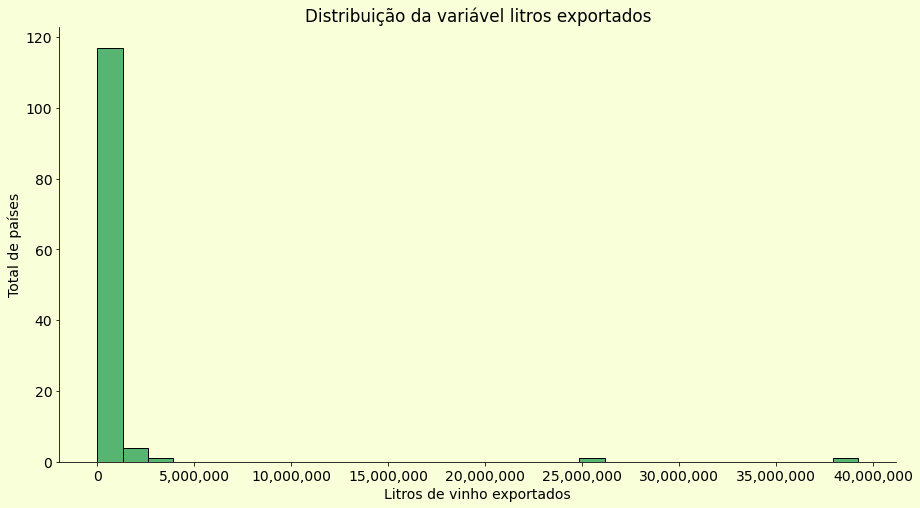

In [134]:
# Ajustando o tamanho da figura do gráfico.
g = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

ax = sns.histplot(wine_data_temperature['litros_exportados'], bins = 30, color='#239B4F')

# Customização dos eixos e título
ax.set_title('Distribuição da variável litros exportados')
ax.set_xlabel('Litros de vinho exportados')
ax.set_ylabel('Total de países')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
g.patch.set_facecolor('#F8FFD9')

plt.show()

É possível perceber que paísem com números baixíssimos de exportação estão poluindo a análise, sem agregar nenhuma informação relevante. Por isso, estes países serão filtrados da nossa base usando o limiar de no mínimo 10 mil litros exportados.

In [135]:
wine_data_temperature_filtered = wine_data_temperature.query('litros_exportados > 10000').reset_index(drop=True)
wine_data_temperature_filtered

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media
0,Brasil,Rússia,RUS,39230153,25559026,-5.35
1,Brasil,Paraguai,PRY,25423559,32364257,23.55
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55
3,Brasil,China,CHN,2411701,4372268,7.50
4,Brasil,Espanha,ESP,1993000,3808552,13.30
5,Brasil,Japão,JPN,1502311,2612375,11.15
6,Brasil,Países Baixos,NLD,1410166,4119122,9.25
7,Brasil,Reino Unido,GBR,1305329,4717554,8.45
8,Brasil,Haiti,HTI,1238100,1586194,24.90
9,Brasil,Alemanha,DEU,1020933,2739079,8.40


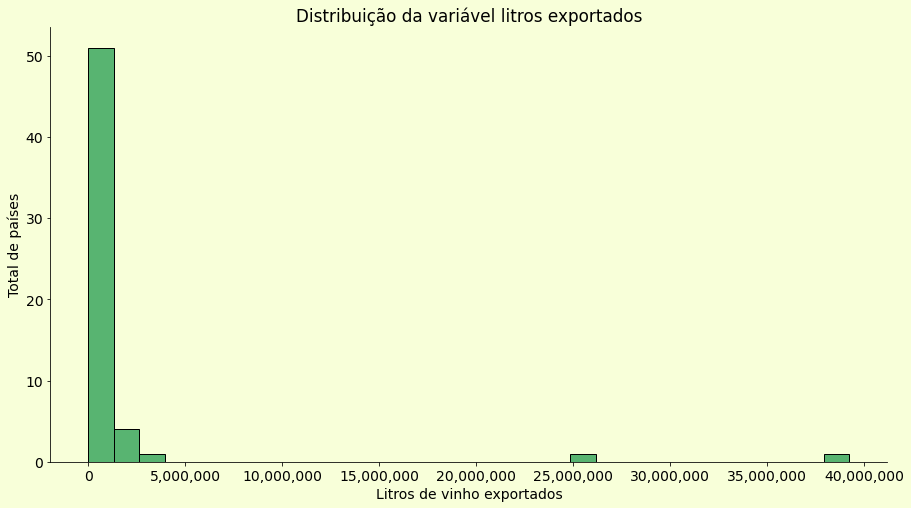

In [136]:
# Ajustando o tamanho da figura do gráfico.
g = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

ax = sns.histplot(wine_data_temperature_filtered['litros_exportados'], bins = 30, color='#239B4F')

# Customização dos eixos e título
ax.set_title('Distribuição da variável litros exportados')
ax.set_xlabel('Litros de vinho exportados')
ax.set_ylabel('Total de países')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
g.patch.set_facecolor('#F8FFD9')

plt.show()

Ainda assim, a distribuição da variável continua bastante assimétrica, indicando que o Brasil exporta baixas quantidades de vinho para a maioria dos países do mundo, porém possui grandes parceiros comerciais específicos.

## Litros exportados x Valor de exportação

Na maioria das vezes maiores quantidades de vinho exportadas representarão um maior valor de exportação. Porém, é também importante verificar o valor do litro exportado para cada país e com isso identificar para quais países a venda do Brasil é mais rentável ou então para onde estão indo os vinhos de maior qualidade.

In [137]:
# Aplicação do pd.melt() para facilitar construção de alguns tipos de gráficos como o gráfico de barras múltiplas
wine_data_melted = wine_data_temperature_filtered.drop(columns=['pais_origem', 'iso_cod'])
wine_data_melted = pd.melt(wine_data_melted, id_vars='pais_destino')
wine_data_melted

,pais_destino,variable,value
0,Rússia,litros_exportados,39230153.00
1,Paraguai,litros_exportados,25423559.00
2,Estados Unidos,litros_exportados,3822251.00
3,China,litros_exportados,2411701.00
4,Espanha,litros_exportados,1993000.00
...,...,...,...
169,Catar,temp_anual_media,27.15
170,Bahamas,temp_anual_media,24.85
171,Cabo Verde,temp_anual_media,23.30
172,Emirados Árabes Unidos,temp_anual_media,26.65


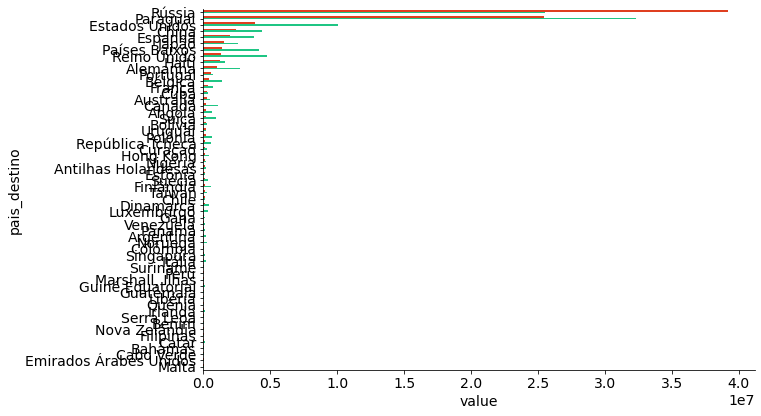

In [138]:
# Criando a paleta para o gráfico
paleta=sns.color_palette(['#ff2a00', '#04E08A'])

# Criando o gráfico de barras de comparação.
g = sns.catplot(data=wine_data_melted.iloc[:, :10], y="pais_destino", x="value", hue="variable", kind="bar", height=6, aspect=1.8, palette=paleta, legend=False)

plt.show()